In [1]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib import offsetbox

import re
import nltk
import spacy
import pickle

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
### LOAD DRESS ###
data = pd.read_csv('FEIDEGGER.csv').fillna(' ')
print(data.shape)
data.head(3)

(43944, 2)


,Image URL,Description
0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"kurze, sexy, sommer, sexy, party, gelb kleid, ..."
1,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,ein gelbes kleid welches eine länge bis etwa ü...
2,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"Knielanges Stoffkleid in gelb mit weitem Rock,..."


In [3]:
### MERGE DESCRIPTION 4 IMAGE URL ###
newdata = data.groupby('Image URL')['Description'].apply(lambda x: x.str.cat(sep=' ')).reset_index()
print(newdata.shape)
newdata.head(3)

(8792, 2)


,Image URL,Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,"Ein weißes, knöchellanges Kleid. Es hat einen ..."
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,Ein rotes faltiges Kleid mit mittellangen Ärme...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,"Ein Schwarzes etwa Knielanges Kleid, mit einem..."


In [4]:
### LOAD VGG ###
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
### PREPARE IMAGES FOR VGG ###
## A) READ IMAGES AND EXPAND DIM
importedImages = []

for url in tqdm(newdata['Image URL'][0:5]):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    importedImages.append(img_batch.astype('float16'))
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
### EXTRACT FEATURES ###
## B) MAKE PREDICTION
imgs_features = feat_extractor.predict(processed_imgs)
imgs_features.shape

In [5]:
### A + B (DONE AND STORED IN A PICKLE) ###
with open("./img2feat.pkl", 'rb') as pickle_file:
    imgs_features = pickle.load(pickle_file)

print(imgs_features.shape)

(8792, 4096)


In [6]:
### SPLIT TRAIN TEST ###
train = imgs_features[:8000]
print(train.shape)

test = imgs_features[8000:]
print(test.shape)

(8000, 4096)
(792, 4096)


# VISUALIZE DRESS

In [7]:
### REDUCE FEATURE DIMENSIONS ###
pca = PCA(n_components=50, random_state=33)
pca_score = pca.fit_transform(imgs_features)

tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=5)
T = tsne.fit_transform(pca_score)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.82it/s]


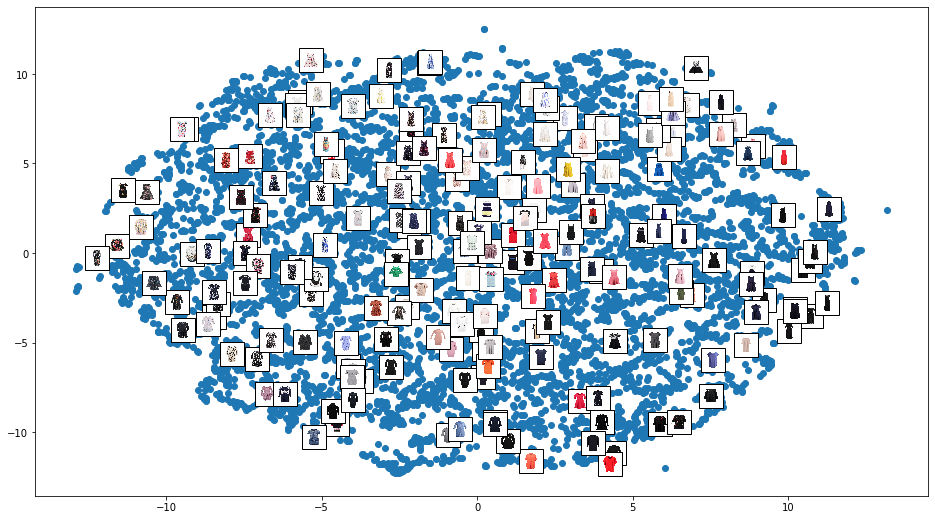

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) 
plt.grid(False)

shown_images = np.array([[1., 1.]])
for i in tqdm(np.random.randint(1,T.shape[0],200)):
    
    response = requests.get(newdata['Image URL'][i])
    img = Image.open(BytesIO(response.content))
    img = img.resize((16, 16))
    
    shown_images = np.r_[shown_images, [T[i]]]
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, cmap=plt.cm.gray_r), T[i])
    ax.add_artist(imagebox)

plt.show()

# IMAGES SIMILARITY

In [9]:
### PASS THE TEST ID TO GET THE MOST SIMILAR PRODUCTS ###
def most_similar_products(test_id, n_sim = 3):
    
    #open-plot image
    plt.subplot(1, n_sim+1, 1)
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    
    #compute similarity matrix
    cosSimilarities_serie = cosine_similarity(train, test[test_id].reshape(1,-1)).ravel()
    cos_similarities = pd.DataFrame({'sim':cosSimilarities_serie,'id':newdata[:train.shape[0]].index},
                                    index=newdata['Image URL'][:train.shape[0]]).sort_values('sim',ascending=False)[0:n_sim+1]

    #plot n most similar
    for i in range(0,n_sim):
        
        plt.subplot(1, n_sim+1, i+1+1)
        org_response = requests.get(cos_similarities.index[i])
        original = Image.open(BytesIO(org_response.content))
        original = original.resize((224, 224))
        plt.imshow(original)
        plt.title('Similar'+str(i+1)+': '+str(cos_similarities.sim[i].round(3)))

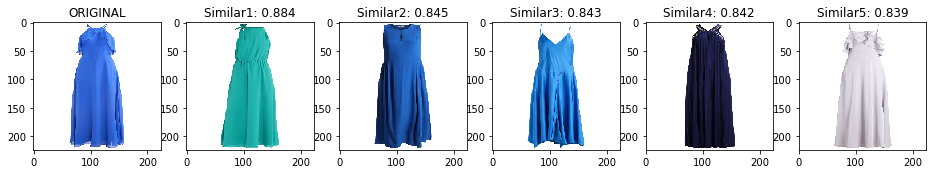

In [10]:
plt.figure(figsize=(16,8))
most_similar_products(7,5)
plt.show()

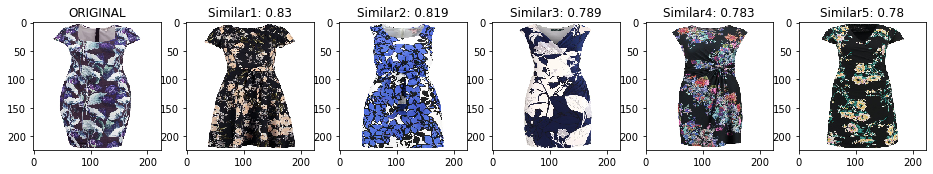

In [11]:
plt.figure(figsize=(16,8))
most_similar_products(28,5)
plt.show()

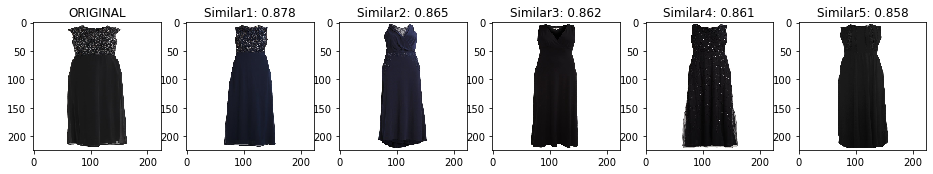

In [12]:
plt.figure(figsize=(16,8))
most_similar_products(9,5)
plt.show()

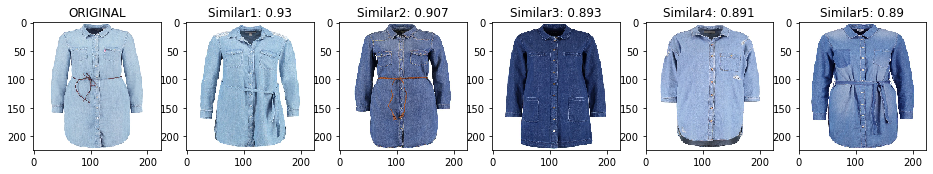

In [13]:
plt.figure(figsize=(16,8))
most_similar_products(10,5)
plt.show()

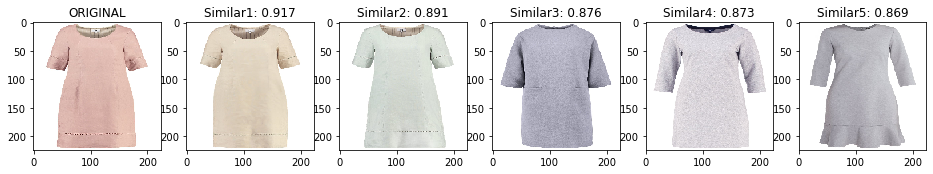

In [14]:
plt.figure(figsize=(16,8))
most_similar_products(347,5)
plt.show()

# TEXT SIMILARITY

In [15]:
del newdata

In [16]:
### CLEAN DESCRIPTION ###
tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-ZäöüßÄÖÜ]+')
nlp = spacy.load('de_core_news_sm')

# keep only noun and adj: return lemma
def clean(txt):

    text = tokenizer.tokenize(txt)
    text = nlp(" ".join(text))
    adj, noun = [], []
    for token in text:
        if token.pos_ == 'ADJ' and len(token)>2:
            adj.append(token.lemma_)
        elif token.pos_ in ['NOUN','PROPN'] and len(token)>2: 
            noun.append(token.lemma_)
            
    return " ".join(adj).lower(), " ".join(noun).lower()

adj, noun = zip(*map(clean,tqdm(data['Description'])))
data['adj_Description'] = list(adj)
data['noun_Description'] = list(noun)

100%|███████████████████████████████████████████████████████████████████████████| 43944/43944 [07:09<00:00, 102.30it/s]


In [17]:
### MERGE CLEAN DESCRIPTION 4 IMAGE URL ###
newdata = data.groupby('Image URL')['adj_Description'].apply(lambda x: x.str.cat(sep=' XXX ')).reset_index()
newdata['noun_Description'] = data.groupby('Image URL')['noun_Description'].apply(lambda x: x.str.cat(sep=' XXX ')).values
print(newdata.shape)
newdata.head(3)

(8792, 3)


,Image URL,adj_Description,noun_Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,weiß knöchellanges puffige breit weiß faltig X...,kleid rundausschnitt ärmel taillenbereich quer...
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,rot faltig mittellangen schulterfrei XXX schle...,kleid ärmel knie XXX knielanges stoffkleid fal...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,schwarze halbrundem XXX knielanges schwarz run...,schwarzes knielanges kleid schnalle gürtel bau...


In [18]:
### DEFINE UTILITY FUNCTION TO OPERATE WITH TEXT ###
remove_adj = ['rund','lang','kurz','kurze','klein','knien','langen','weit']
remove_noun = ['kleid','ärmel','ausschnitt','rock','knie','knielanges','halsen','seite',
               'träge','träger','arm','brust','fuß','schulter','taille','oberteil']

# extract most important words with tfidf
# complete empty space with 'xxx'
def tagging(comments, remove=None, n_word=3):
    
    comments = comments.split('XXX')
    try:
        counter = TfidfVectorizer(min_df=2, analyzer='word', stop_words=remove)
        counter.fit(comments)
        score = counter.transform(comments).toarray().sum(axis=0)
        word = counter.get_feature_names()
        vocab = pd.DataFrame({'w':word,'s':score}).sort_values('s').tail(n_word)['w'].values
        return  " ".join(list(vocab)+['xxx']*(n_word-len(vocab)))
    except:
        return  " ".join(['xxx']*n_word)

In [19]:
### GENERATE LABELS: EXTRACT MOST IMPORTANT WORD ###
tag_noun = newdata['noun_Description'][:train.shape[0]].progress_apply(lambda x: tagging(x,remove_noun))
tag_adj = newdata['adj_Description'][:train.shape[0]].progress_apply(lambda x: tagging(x,remove_adj))
label_noun = np.asarray(tag_noun.str.cat(sep=' ').split(' '))
label_adj = np.asarray(tag_adj.str.cat(sep=' ').split(' '))

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:21<00:00, 368.02it/s]


In [20]:
### GENERATE TRAIN FEATURES: REPLICATE FEATURES WITH THE SAME ORDER OF LABELS ###
features = np.repeat(train, 3, axis=0)

print(features.shape)

(24000, 4096)


In [21]:
### ENCODE LABELS FOR NN ###
y_noun = to_categorical(pd.Series(label_noun[label_noun!='xxx']).factorize()[0])
y_adj = to_categorical(pd.Series(label_adj[label_adj!='xxx']).factorize()[0])
print(y_noun.shape)
print(y_adj.shape)

(7291, 451)
(15960, 328)


In [22]:
### DEFINE ADJ AND NOUN MODELS ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model_adj():
    
    set_seed(33)
    
    inp_adj = Input(shape=(4096,))
    dense_adj1 = Dense(256, activation='relu')(inp_adj)
    dense_adj2 = Dense(128, activation='relu')(dense_adj1)
    drop_adj = Dropout(0.5)(dense_adj2)
    dense_adj3 = Dense(64, activation='relu')(drop_adj)
    out_adj = Dense(y_adj.shape[1], activation='softmax')(dense_adj3)

    model_adj = Model(inputs=inp_adj, outputs=out_adj)
    model_adj.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model_adj


def get_model_noun():
    
    set_seed(33)

    inp_noun = Input(shape=(4096,))
    dense_noun1 = Dense(256, activation='relu')(inp_noun)
    dense_noun2 = Dense(128, activation='relu')(dense_noun1)
    drop_noun = Dropout(0.5)(dense_noun2)
    dense_noun3 = Dense(64, activation='relu')(drop_noun)
    out_noun = Dense(y_noun.shape[1], activation='softmax')(dense_noun3)

    model_noun = Model(inputs=inp_noun, outputs=out_noun)
    model_noun.compile(optimizer='adam', loss='categorical_crossentropy')
    
    return model_noun

In [23]:
### FIT ADJ MODEL ###
model_adj = get_model_adj()
model_adj.fit(features[label_adj!='xxx'], y_adj, epochs=10, batch_size=512, verbose=2)

Train on 15960 samples
Epoch 1/10
15960/15960 - 2s - loss: 4.3006
Epoch 2/10
15960/15960 - 1s - loss: 3.4009
Epoch 3/10
15960/15960 - 1s - loss: 3.2863
Epoch 4/10
15960/15960 - 1s - loss: 3.2058
Epoch 5/10
15960/15960 - 1s - loss: 3.1516
Epoch 6/10
15960/15960 - 1s - loss: 3.0925
Epoch 7/10
15960/15960 - 1s - loss: 3.0394
Epoch 8/10
15960/15960 - 1s - loss: 2.9924
Epoch 9/10
15960/15960 - 1s - loss: 2.9688
Epoch 10/10
15960/15960 - 1s - loss: 2.9400


In [24]:
### FIT NOUN MODEL ###
model_noun = get_model_noun()
model_noun.fit(features[label_noun!='xxx'], y_noun, epochs=10, batch_size=512, verbose=2)

Train on 7291 samples
Epoch 1/10
7291/7291 - 1s - loss: 5.7169
Epoch 2/10
7291/7291 - 0s - loss: 4.7101
Epoch 3/10
7291/7291 - 0s - loss: 4.3620
Epoch 4/10
7291/7291 - 0s - loss: 4.2474
Epoch 5/10
7291/7291 - 0s - loss: 4.1476
Epoch 6/10
7291/7291 - 0s - loss: 4.0564
Epoch 7/10
7291/7291 - 0s - loss: 3.9812
Epoch 8/10
7291/7291 - 0s - loss: 3.8918
Epoch 9/10
7291/7291 - 0s - loss: 3.8506
Epoch 10/10
7291/7291 - 0s - loss: 3.7472


In [25]:
def tag_products(test_id):
    
    # open-plot image
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id])
    original = Image.open(BytesIO(org_response.content))
    original = original.resize((224, 224))
    plt.imshow(original)
    plt.title('ORIGINAL')
    plt.show()
    
    #pred noun
    pred_noun = model_noun.predict(test[test_id].reshape(1,-1))
    pred_noun_class = np.argsort(-pred_noun)[0][0:2]
    return_noun_class = pd.Series(label_noun[label_noun!='xxx']).factorize()[1][pred_noun_class].tolist()

    #pred adj
    pred_adj = model_adj.predict(test[test_id].reshape(1,-1))
    pred_adj_class = np.argsort(-pred_adj)[0][0:2]
    return_adj_class = pd.Series(label_adj[label_adj!='xxx']).factorize()[1][pred_adj_class].tolist()

    print('NOUN:', return_noun_class,'\n','ADJ:',return_adj_class)

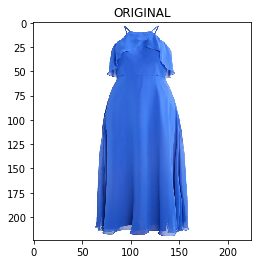

NOUN: ['abendkleid', 'schlitz'] 
 ADJ: ['blau', 'knielanges']


In [26]:
tag_products(7)

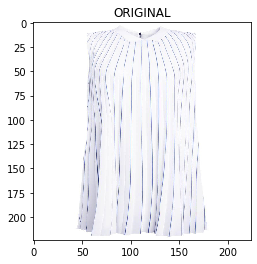

NOUN: ['streife', 'minikleid'] 
 ADJ: ['weiß', 'schwarz']


In [27]:
tag_products(8)

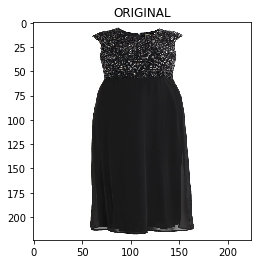

NOUN: ['abendkleid', 'spitzen'] 
 ADJ: ['schwarz', 'ärmellos']


In [28]:
tag_products(9)

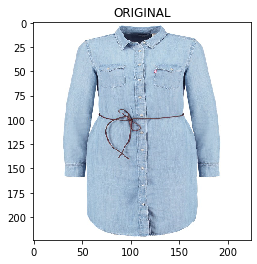

NOUN: ['jeanskleid', 'tasche'] 
 ADJ: ['blau', 'hellblaues']


In [29]:
tag_products(10)

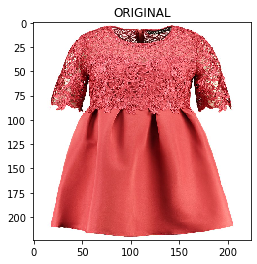

NOUN: ['spitzen', 'minikleid'] 
 ADJ: ['rot', 'knielanges']


In [30]:
tag_products(11)

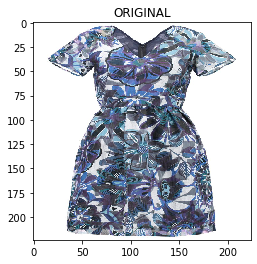

NOUN: ['blumenmuster', 'mustern'] 
 ADJ: ['blau', 'weiß']


In [31]:
tag_products(278)

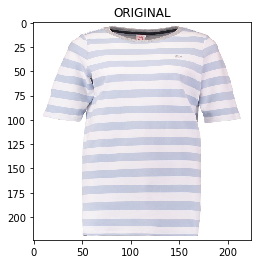

NOUN: ['streife', 'minikleid'] 
 ADJ: ['weiß', 'schwarz']


In [32]:
tag_products(1)